# Chapter 6 - Graph Embeddings

In this notebook, we illustrate several graph embedding algorithms, we show how we can compare embeddings using an unsupervised framework, and we look at various applications such as clustering, link prediction and anomaly detection.

### Requirements

- install node2vec code (see https://snap.stanford.edu/node2vec)
- compile GED code (graph embedding divergence), 
  the base implementation of the framework in C (the code is included, and can also be found at      https://github.com/ftheberge/Comparing_Graph_Embeddings) 
- new package to install: 'pip install --no-dependencies graphrole'

Also set the path(s) in the cell below. For Windows, you may need to use "\\" or "\\\\" as delimiters, for example 'C:\\\\node2vec\\\\node2vec.exe'

Also for windows, "cp" should be changed to "copy" when keeping track of best and worst embeddings.

### Non-deterministic results

Some of the results in this notebook may vary from run to run in particular for node2vec (which uses random walks) and for 2-d renditions of high-dimensional embeddings via UMAP.


In [1]:
## the data directory
datadir = '../Datasets/'

#julia = '/work/home/fcthebe/julia-1.7.2/bin/julia '
julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia ' ## you may need the full path here

## location of the CGE code (Comparing Graph Embeddings framework)
CGE = '../CGE/CGE_CLI.jl '


In [2]:
import igraph as ig
import partition_igraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse.linalg as lg
import subprocess
import os
import umap
from fastnode2vec import Graph, Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import calinski_harabasz_score as CHS
from sklearn.metrics import adjusted_mutual_info_score as AMI
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
import pickle

## node and edge greyscale colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']


# A few useful functions

In [3]:
# ## as defined in the node2vec paper
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0

# ## 'N2K' mapping is used to map between node name and key value in graph when reading results from node2vec
def readEmbedding(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
#     if N2K!=None:
#         x = [N2K[i] for i in D[0]]
#         D[0] = x    
#         D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
def embed2layout(fn="_embed", seed=123, n_jobs=1):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP(random_state=seed, n_jobs=n_jobs).fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with julia framework code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, return_local=False):
    x = julia+CGE+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file+' 2>_stderr'
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(',')
    if return_local:
        return (float(x[1]),float(x[5]))
    else:
        return float(x[1])


## Hope embedding with various similarity functions
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    ## For undirected graphs, embedding as source and target are identical
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        ## fix bug 1/x and take log();
        D = np.diag([1/np.log(x) if x>1 else 0 for x in g.degree()]) 
        # D = np.diag([1/np.log(max(2,x)) for x in g.degree()]) 
        M_l = np.dot(np.dot(A,D),A)
        np.fill_diagonal(M_l,0)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## presonalized page rank
    if sim == 'ppr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            if s>0:
                P.append([x/s for x in A[i]])
            else:
                P.append([1/n for x in A[i]])
        P = np.transpose(np.array(P)) ## fix bug - take transpose
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2)
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    ## undirected graphs have identical source and target embeddings
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

# ## Returns a LaTeX bmatrix
def bmatrix(a):
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

## Figure 6.1 in the Book

This is to illustrate random walks on (directed) graphs.


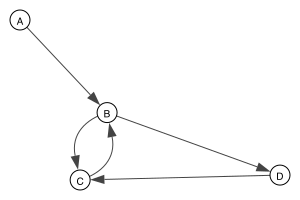

In [4]:
g = ig.Graph.Erdos_Renyi(n=4,p=0,directed=True)
g.vs['label'] = ['A','B','C','D']
g.vs['color'] = 'white'
g.add_edges([(0,1),(1,2),(1,3),(2,1),(3,2)])
#ig.plot(g,'tiny.eps',bbox=(0,0,300,200),vertex_label_size=10)
ig.plot(g,bbox=(0,0,300,200), vertex_label_size=10)

# Load and prepare some datasets

* $abcd$: is a small ABCD graph (100 nodes), mainly for visualization and quick exampes
* $ABCD$: is a larger ABCD graph (1000 nodes), for experiments
* $zac$: Zachary (karate club) graph, for visualzation

The small ABCD graph was generated with the following parameters:

```
n = "100"                     # number of vertices in graph
t1 = "3"                      # power-law exponent for degree distribution
d_min = "5"                   # minimum degree
d_max = "15"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "2"                      # power-law exponent for cluster size distribution
c_min = "25"                  # minimum cluster size
c_max = "50"                  # maximum cluster size
c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
xi = "0.2"                    # fraction of edges to fall in background graph
isCL = "false"                # if "false" use configuration model, if "true" use Chung-Lu
```

The larger ABCD graph was generated with the following parameters:

```
n = "1000"                     # number of vertices in graph
t1 = "3"                       # power-law exponent for degree distribution
d_min = "10"                   # minimum degree
d_max = "100"                  # maximum degree
d_max_iter = "1000"            # maximum number of iterations for sampling degrees
t2 = "2"                       # power-law exponent for cluster size distribution
c_min = "50"                   # minimum cluster size
c_max = "150"                  # maximum cluster size
c_max_iter = "1000"            # maximum number of iterations for sampling cluster sizes
xi = "0.6"                     # fraction of edges to fall in background graph
isCL = "false"                 # if "false" use configuration model, if "true" use Chung-Lu
```


### Load the small ABCD graph and visualize

Node names are integers here, and this should not be confused with the key used in igraph to enumerate the nodes.
In order to avoid such issues, we define a dictionary, *n2k*, to map between node name and its key value.


100 vertices, 350 edges, avg degreee 7.0 communities 3


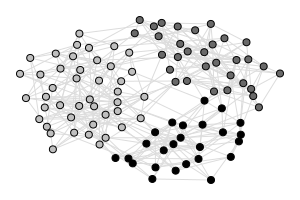

In [5]:
## read graph and communities
abcd = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))
abcd.vs['comm'] = [c[int(x['name'])-1] for x in abcd.vs]

## print a few stats
print(abcd.vcount(),'vertices,',abcd.ecount(),'edges,','avg degreee',np.mean(abcd.degree()),
      'communities',max(abcd.vs['comm']))

## ground truth communities
gt = {k:(v-1) for k,v in enumerate(abcd.vs['comm'])}

## map between int(name) to key
# n2k = {int(v):k for k,v in enumerate(abcd.vs['name'])}

## define the colors and node sizes here
abcd.vs['size'] = 7
abcd.es['color'] = cls_edges
abcd.vs['color'] = [cls[i-1] for i in abcd.vs['comm']]

#ig.plot(abcd, 'abcd.eps', bbox=(0,0,300,200))
ig.plot(abcd, bbox=(0,0,300,200))

### Load the larger ABCD graph and visualize

This is a larger graph with lots of noise edges ($\xi$=0.6). Nore colours refer to the communities.
With this amount of noise, the communities are far from obvious on a 2-dim layout.

We'll use a version with stronger communities ($\xi$=0.2) for link prediction.


In [6]:
## read graph and communities
ABCD = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
ABCD.vs['comm'] = [c[int(x['name'])-1] for x in ABCD.vs]

## print a few stats
print(ABCD.vcount(),'vertices,',ABCD.ecount(),'edges,','avg degreee',np.mean(ABCD.degree()),
      'communities',max(ABCD.vs['comm']))

## ground truth communities
GT = {k:(v-1) for k,v in enumerate(ABCD.vs['comm'])}

## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(ABCD.vs['name'])}

## define the colors and node sizes here
## node colors refer to communities
cls_edges = 'gainsboro'
ABCD.vs['size'] = 5
ABCD.es['color'] = cls_edges
pal = ig.RainbowPalette(n=max(ABCD.vs['comm'])+1) 
ABCD.vs['color'] = [pal.get(int(i)) for i in ABCD.vs['comm']]
#ABCD.vs['color'] = 'black'

ig.plot(ABCD, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

1000 vertices, 8327 edges, avg degreee 16.654 communities 12


### Zachary (karate club) graph

This graph is already included with igraph.


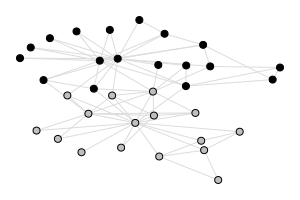

In [7]:
zac = ig.Graph.Famous('zachary')
zac.vs['size'] = 7
zac.vs['name'] = [str(i) for i in range(zac.vcount())]
zac.es['color'] = cls_edges
zac.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
zac.vs['color'] = [cls[i*2] for i in zac.vs['comm']]
#ig.plot(zac, 'zachary.eps', bbox=(0,0,300,200))
ig.plot(zac, bbox=(0,0,300,200))

## Graph layouts 

We show a variety of graph layout functions available in igraph on the Zachary graph.


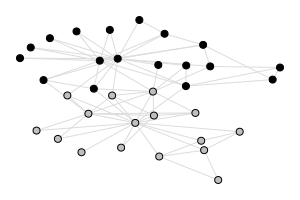

In [8]:
## Kamada-Kawai layout
ly = zac.layout('kk')

#ig.plot(zac, 'layout_kk.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))


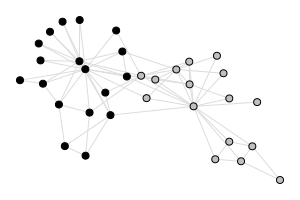

In [9]:
## Fruchterman-Reingold layout
ly = zac.layout('fr')

#ig.plot(zac, 'layout_fr.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

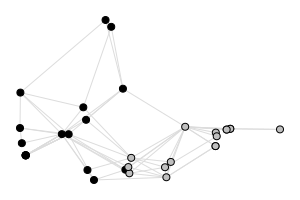

In [10]:
## Multidimensional scaling layout
ly = zac.layout('mds')

#ig.plot(zac, 'layout_mds.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

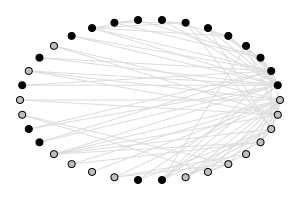

In [11]:
## Circular layout
ly = zac.layout('circle')

#ig.plot(zac, 'layout_circle.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

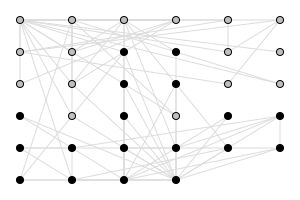

In [12]:
## Grid layout
ly = zac.layout('grid')

#ig.plot(zac, 'layout_grid.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

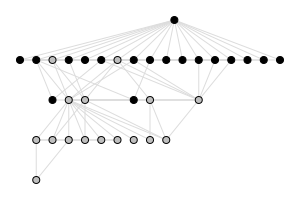

In [13]:
## Sugiyama layout
ly = zac.layout('sugiyama')

#ig.plot(zac, 'layout_tree.eps', layout=ly, bbox=(0,0,300,200))
ig.plot(zac, layout=ly, bbox=(0,0,300,200))

# Generate several embeddings -- Zachary graph

We try a few graph embedding algorithms on the Zachary graph with
different parameters. For example, we try different embedding dimensions.

We run the following:
* node2vec from source code
* HOPE with different similarities
* Laplacian Eigenmaps

For each embedding, we use the ground truth communities along with the framework to compute the "graph embedding divergence" (GED). We visualize some good and bad results.

For embeddings with low divergence, we see good separation of the communities (even in 2-dim projection, using UMAP), while this is not the case for embeddings with high divergence.


In [14]:
L = [] ## to store results
DIM = [2, 4, 8]  ## try embedding in different dimensions
best_jsd = 1    ## keep track of best JS-divergence
worst_jsd = 0   ## and worst one.

## Hope with different choices for the similarity
print('running HOPE')
for dim in DIM:
    for sim in ['katz','ppr','cn','aa']:
        X = Hope(zac, sim=sim, dim=dim) 
        saveEmbedding(X,zac)
        div = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed',return_local=True)      
        jsd = div[0]
        ## keep track of best and worst embeddings
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        L.append([dim,'hope',sim,jsd])

## Laplacian Eigenmap
print('running LE')
for dim in DIM:
    X = LE(zac, dim=dim)
    saveEmbedding(X, zac)
    div = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed',return_local=True)
    jsd = div[0]
    ## keep track of best and worst embeddings
    if jsd < best_jsd:
        os.system('cp _embed _embed_best')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst')
        worst_jsd = jsd
    L.append([dim,'le',' ',jsd])


## node2vec 
print('running node2vec')
graph = Graph(zac.to_tuple_list(), directed=False, weighted=False)
for dim in DIM:
    for (p,q) in [(1,0.5),(0.5,1),(1,1)]:
        ## using default values from original node2vec code
        n2v = Node2Vec(graph, dim=dim, p=p, q=q, walk_length=80, window=5, seed=123)
        n2v.train(epochs=10, verbose=False)
        Y = np.array([n2v.wv[i] for i in range(len(n2v.wv))])
        saveEmbedding(Y, zac)
        div = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed', return_local=True)
        jsd = div[0] ## global divergence
        
        ## keep track of best and worst embeddings
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        
        ## store results
        L.append([dim,'n2v',str(p)+' '+str(q),jsd])

## store results in dataframe, show top results w.r.t. JS divergence (lower is better)        
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()


running HOPE
running LE
running node2vec


Reading graph:   0%|                                                                                | 0/78 [00…

,dim,algo,param,jsd
20,4,n2v,1 1,0.002377
21,8,n2v,1 0.5,0.003221
23,8,n2v,1 1,0.003795
18,4,n2v,1 0.5,0.004132
19,4,n2v,0.5 1,0.004153


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


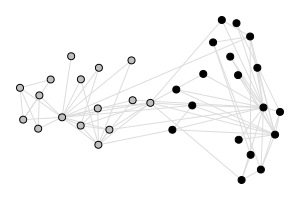

In [15]:
## plot top results
os.system('cp _embed_best _embed')
l = embed2layout(seed=123)
zac.vs['ly'] = [l[int(v['name'])] for v in zac.vs]
#ig.plot(z, 'zac_high.eps', layout=z.vs['ly'], bbox=(0,0,300,200))
ig.plot(zac, layout=zac.vs['ly'], bbox=(0,0,300,200))

In [16]:
## results with largest JS divergence
D.tail()

,dim,algo,param,jsd
10,8,hope,cn,0.012326
7,4,hope,aa,0.012917
6,4,hope,cn,0.013775
4,4,hope,katz,0.013940
3,2,hope,aa,0.025238


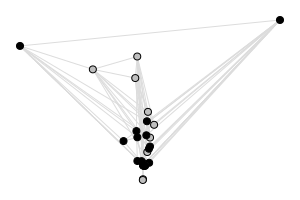

In [17]:
## plot result with largest divergence
os.system('cp _embed_worst _embed')
l = embed2layout(seed=123)
zac.vs['ly'] = [l[int(v['name'])] for v in zac.vs]
#ig.plot(zac, 'zac_high.eps', layout=z.vs['ly'], bbox=(0,0,300,200))
ig.plot(zac,layout=zac.vs['ly'], bbox=(0,0,300,200))

# Generate several embeddings -- small ABCD  graph

This is the same exercise as what we did above, this time for the 100-nodes ABCD graph.
We look at slightly higher embedding dimensions as there are more nodes than the Zachary graph.

In [18]:
%%time
L = []
DIM = [2,4,8,16]       ## embedding dimensions
best_jsd = 1           ## keep track of best result
worst_jsd = 0          ## and worst

## Hope with different choices for the similarity
print('running HOPE')
for dim in DIM:
    for sim in ['katz','aa','cn','ppr']:
        X = Hope(abcd,sim=sim,dim=dim) 
        saveEmbedding(X,abcd)
        div = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed', return_local=True)
        jsd = div[0]
        
        ## keep track of best and worst
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        L.append([dim,'hope',sim,div[0],div[1]])

## Laplacian Eigenmap
print('running LE')
for dim in DIM:
    X = LE(abcd,dim=dim)
    saveEmbedding(X,abcd)
    div = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed', return_local=True)
    jsd = div[0]
    
    ## keep track of best and worst
    if jsd < best_jsd:
        os.system('cp _embed _embed_best')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('cp _embed _embed_worst')
        worst_jsd = jsd
    L.append([dim,'le',' ',div[0],div[1]])
    
## node2vec 
print('running node2vec')
graph = Graph(abcd.to_tuple_list(), directed=False, weighted=False)
for dim in DIM:
    for (p,q) in [(1,.5),(.5,1),(1,1)]:
        n2v = Node2Vec(graph, dim=dim, p=p, q=q, walk_length=80, window=5, seed=123)
        n2v.train(epochs=10, verbose=False)
        Y = np.array([n2v.wv[i] for i in range(len(n2v.wv))])
        saveEmbedding(Y, abcd)
        div = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed', return_local=True)
        jsd = div[0]

        ## keep track of best and worst
        if jsd < best_jsd:
            os.system('cp _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('cp _embed _embed_worst')
            worst_jsd = jsd
        L.append([dim,'n2v',str(p)+' '+str(q),div[0],div[1]])

## store in dataframe and show best results        
D = pd.DataFrame(L,columns=['dim','algo','param','jsd(global)','jsd(local)'])
D = D.sort_values(by='jsd(global)',axis=0)
D.head()


running HOPE
running LE
running node2vec


Reading graph:   0%|                                                                               | 0/350 [00…

CPU times: user 2.24 s, sys: 294 ms, total: 2.53 s
Wall time: 1min 17s


,dim,algo,param,jsd(global),jsd(local)
30,16,n2v,0.5 1,0.000035,0.0512
25,4,n2v,1 1,0.000040,0.1067
24,4,n2v,0.5 1,0.000054,0.1030
27,8,n2v,0.5 1,0.000054,0.0657
28,8,n2v,1 1,0.000090,0.0896


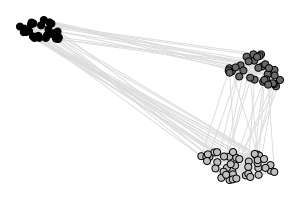

In [19]:
## plot result with lowest global JS divergence
os.system('cp _embed_best _embed')
l = embed2layout(seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))


In [20]:
## results with high divergence
D.tail()

,dim,algo,param,jsd(global),jsd(local)
20,2,n2v,1 0.5,0.025341,0.1764
3,2,hope,ppr,0.031437,0.1917
1,2,hope,aa,0.034727,0.1969
2,2,hope,cn,0.036974,0.2043
0,2,hope,katz,0.037301,0.2054


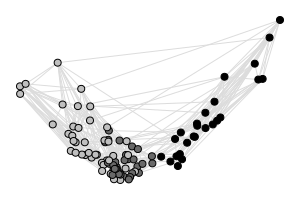

In [21]:
## plot result with high divergence
os.system('cp _embed_worst _embed')
l = embed2layout(seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))


### effect of local divergence score

So far we considered the global Jenssen-Shannon divergence, where the objective is to preserve the community structure.

The best results we saw above indeed preserves the community structure, but we may want better separation of the nodes within community, based on their connectivity. This is what the local Jenssen-Shannon divergence can provide. 

Below we show an embedding with lower local divergence, and higher global divergence (albeit still low) compared with the best result shown abive. The result is an embedding that still preserves community structure, but nodes within community are more separated than with the global divergence.


In [22]:
## look at results with low local divergence
D.sort_values(by='jsd(local)').head()

,dim,algo,param,jsd(global),jsd(local)
19,16,le,,0.000333,0.0128
15,16,hope,ppr,0.000455,0.0148
18,8,le,,0.000426,0.0452
11,8,hope,ppr,0.000319,0.0480
30,16,n2v,0.5 1,0.000035,0.0512


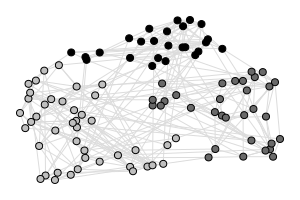

In [23]:
## Plot embedding with Laplacian Eigenmap
dim = 16
X = LE(abcd,dim=dim)
saveEmbedding(X,abcd)
l = embed2layout(seed=123)
abcd.vs['ly'] = [l[int(v['name'])-1] for v in abcd.vs]
ig.plot(abcd, layout=abcd.vs['ly'], bbox=(0,0,300,200))


# Classification on larger ABCD graph

We saw that embedding can be used to visualize graphs. Below we use graph embedding as a way to define a feature vector (point in vector space) for each node, and we use this representation to train a classifier.
We use a saved embedding (48-dimension running HOPE with 'ppr' similarity).

We split the data (the nodes) into a training and testing set. Using the training set, we build a random forest classification model where the classes are the communities for each node.

We then apply this model to the test set.

The graph has 1000 nodes; we use 250 for training and the rest for testing; we obtain good accuracy (around 90%).
What do you think will happen if we increase/decrease the size of the training set?

WE also report the confusion matrix (details in section 6.5 of the book).

Finally, we compare with results obtained via a random classifier where we supply the correct number of classes only, or the number and relative sizes for the classes.

We see that our random forest model gives much better results that with a random classifier.


In [24]:
## load a saved embedding for ABCD graph
X = readEmbedding(fn=datadir+"ABCD/abcd_1000_embed_best")
y = ABCD.vs['comm']

## train/test split
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)


In [25]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

# Class predictions on test data
y_pred = model.predict(X_test)

In [26]:
## Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

## percent correct -- this can vary slightly as we split train/test randomly
print('\naccuracy:',sum(cm.diagonal())/sum(sum(cm)),'\n')
#print(bmatrix(cm))

[[78  1  4  0  0  2  3  0  3  0  1  0]
 [ 0 77  0  1  1  0  0  1  0  0  0  0]
 [ 1  0 71  0  1  0  0  0  3  0  0  0]
 [ 1  1  1 64  0  1  0  1  1  0  0  0]
 [ 1  0  2  1 77  0  0  1  0  1  0  0]
 [ 0  0  0  1  1 54  0  1  0  0  0  0]
 [ 1  1  0  0  1  3 53  3  2  0  0  0]
 [ 0  0  0  1  1  0  0 42  0  0  0  0]
 [ 0  0  0  0  1  1  0  1 45  0  0  0]
 [ 1  0  0  0  0  1  0  0  1 44  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 42  0]
 [ 1  1  1  0  0  4  2  2  1  0  0 35]]

accuracy: 0.9093333333333333 



In [27]:
## compare with random classifier -- assuming we know the number of classes (12)
acc = []
for rep in range(30): ## repeat 30 times, we'll take average
    y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True)]
    cm = confusion_matrix(y_test, y_pred)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))
## accuracy
print('\nAverage accuracy:',np.mean(acc))


Average accuracy: 0.08582222222222222


In [28]:
## compare with random classifier -- using class proportions in training data
ctr = Counter(y_train)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
acc = []
for rep in range(30): ## repeat 30 times, we'll take average
    y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
    cm = confusion_matrix(y_test, y_pred)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))
## accuracy
print('\nAverage accuracy:',np.mean(acc))



Average accuracy: 0.08515555555555555


# Clustering in embedded space

Again using the larger ABCD graph, we run some graph clustering algorithms (Leiden and ECG).
We run each algorithm several times are report two statistics:
* the modularity score of the clustering, and
* the adjusted mutual information (AMI) score when comparing with ground-truth (GT) communities.

We also try seeding Leiden with initial clusters obtained with k-means with k=100.

We do the same this also with the clusters obtained when running k-means (with 5 choices for k) in embedded vector space. 
We use the same saved embedding than in the previous experiment. 
This time, we report:
* the CHS score (Calinski and Harabasz score, or Variance Ratio Criterion)
* the adjusted mutual information (AMI) score when comparing with ground-truth (GT) communities.

In practical applications where we do not have access to the ground-truth, we need some other measure to quantify the quality of the clusters we obtain, such as modularity or CHS. We report AMI for runs with highest score (modularity or CHS) for the 3 clustering algorithms.

The cell below can take a few minutes to run. You can decrease the number of repeats (REP) for faster results.

In [29]:
## load the saved embedding
X = readEmbedding(fn=datadir+"ABCD/abcd_1000_embed_best")

L = [] ## to store results
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30 ## number of repeats; decrease for faster run

for i in range(REP):
    
    ## run kmeans
    for k in K:
        cl = KMeans(n_clusters=k, n_init=10).fit(X)
        d = {k:v for k,v in enumerate(cl.labels_)}
        scr = CHS(X,cl.labels_) ## CHS
        ami = AMI(list(GT.values()),list(d.values())) ## AMI vs ground truth
        L.append(['km'+str(k),scr,ami])

    ## ECG
    ec = ABCD.community_ecg().membership
    scr = ABCD.modularity(ec) ## modularity
    ami = AMI(list(GT.values()),ec) ## AMI vs ground truth
    L.append(['ecg',scr,ami])
    
    ## Leiden 
    lei = ABCD.community_leiden(objective_function='modularity')
    scr = ABCD.modularity(lei) ## modularity
    ami = AMI(list(GT.values()),lei.membership) ## AMI vs ground truth
    L.append(['lei', scr, ami])
    
    ## kmeans+Leiden
    cl = KMeans(n_clusters=100, n_init=10).fit(X)
    d = {k:v for k,v in enumerate(cl.labels_)}
    lei = ABCD.community_leiden(objective_function='modularity', initial_membership=cl.labels_)
    scr = ABCD.modularity(lei) ## modularity
    ami = AMI(list(GT.values()),lei.membership) ## AMI vs ground truth
    L.append(['km+lei', scr, ami])

## store in dataframe
D = pd.DataFrame(L,columns=['algo','scr','ami'])


In [30]:
## AMI results with best scoring clustering for the 3 algorithms
x = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means AMI:',x)

x = list(D[D['algo']=='lei'].sort_values(by='scr',ascending=False)['ami'])[0]
print('Leiden AMI:',x)

x = list(D[D['algo']=='ecg'].sort_values(by='scr',ascending=False)['ami'])[0]
print('ECG AMI:',x)

x = list(D[D['algo']=='km+lei'].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means+Leiden AMI:',x)


K-Means AMI: 0.9538782069664211
Leiden AMI: 0.9952939155260987
ECG AMI: 0.9952939155260987
K-Means+Leiden AMI: 0.9952939155260987


Next, we summarize the results for all runs in a boxplot. 
Results with k-means are best when we supply the correct number of clusters (12). 
We also see the high variability when using Louvain instead of ECG.


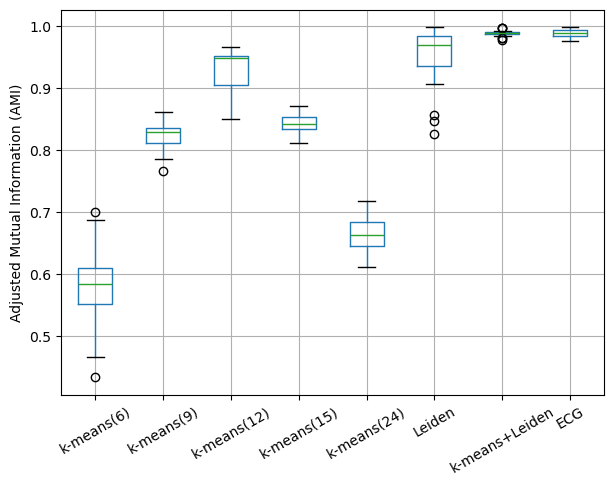

In [31]:
## boxplot the AMI results 
A = []
algo = ['km6','km9','km12','km15','km24','lei','km+lei','ecg']
for a in algo:
    A.append(D[D['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)','Leiden','k-means+Leiden','ECG'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)');
#plt.savefig('embed_cluster.eps')

Below we cluster using the DBSCAN algorithm after reducing the dimension via UMAP.
We found that running a good dimension reduction algorithm before clustering often gives better results.
This is for illustration and
you can experiment with different choices of parameter below as well as diffferent clustering algorithms.

DBSCAN does not always cluster all the points, which can be quite useful in practice. Some points can be tagged as "outliers". Below, we compute AMI with and without the outlying points. 
Result without outliers is quite good (recall that unlike k-mens, we do not supply the number of communities here).


In [32]:
## DBSCAN -- we tried a few 'min_sample' and 'dim' below
## with good results using 8 and 16 resp.
## we try various 'eps' and pick the best via calinski_harabasz_score (CHS)
top = 0
for dim in [16]: ## reduce to this dimension
    for ms in [8]: ## min-sample in DBSCAN
        U = umap.UMAP(n_components=dim).fit_transform(X)
        for e in np.arange(.4,.5,.0025): ## try different values for epsilon
            cl = DBSCAN(eps=e, min_samples=ms ).fit(U)
            labels = cl.labels_
            s = CHS(U,labels) ## CHS score
            if s > top:
                top=s
                e_top=e
                d_top=dim
                m_top=ms

## result with best CHS score
U = umap.UMAP(n_components=d_top).fit_transform(X) 
cl = DBSCAN(eps=e_top, min_samples=m_top).fit(U)

b = [x>-1 for x in cl.labels_]
l = list(GT.values())
v = [l[i] for i in range(len(l)) if b[i]]
print('AMI without outliers:',AMI(v,cl.labels_[b]))
print('AMI with outliers:',AMI(list(GT.values()),cl.labels_))


AMI without outliers: 0.8583918956632519
AMI with outliers: 0.645016874302048


# Link prediction

Given a graph, link prediction aims at finding pairs of nodes not linked by an edge that are the most likely to actually have an edge between them. This could happen if we have a partial view of a graph, for example if edges 
are observed over some period of time, which new edges are we most likely to observe next?

In order to simulate this situation, we take the ABCD graph with 1,000 nodes and drop 10% of the edges.
We re-compute the embedding (since the graph has changed), train a logistic regression model using pairs
of nodes with and without an edge, and apply the model to a test set consisting of the dropped edges, and other 
pairs of nodes not linked by an edge.

First we try with the current ABCD graph with noise parameter $\xi=0.6$.
Given the large number of "noise" edges, results are not very good, as expected.

We do another test this time with another ABCD graph with $\xi=0.2$, with much better results.


### Link prediction with noisy ABCD graph


In [33]:
## pick 10% edges at random, save new graph as Gp
test_size = int(np.round(.1*ABCD.ecount()))
np.random.seed(123456)
test_eid = np.random.choice(ABCD.ecount(),size=test_size,replace=False)
Gp = ABCD.copy()
Gp.delete_edges(test_eid)

## are there zero-degree nodes in this subgraph?
print('min degree:',np.min(Gp.degree()))

## compute embedding on Gp with parameters that yielded a good embedding for G
X = Hope(Gp, sim='ppr', dim=48)


min degree: 6


To build a classifier, we take pairs of nodes (some with edge, some without) and we merge the embedding vectors for those 2 nodes using some binary operator. This generates a feature vector for each pair of nodes we consider.

We build the training data by considering all edges in the subgraph, and an equal number of node pairs without an edge.

From this data, we build a logistic regression model to predict edges vs non-edges.

We then apply the model to the test set which includes the dropped edges, and the same number of non-edges.

We report the accuracy and AUC (area under the ROC curve). 
Results are better than random, but not great; recall that $\xi$=0.6, so the majority of edges are noise to start with, so link prediction is very hard in this case. We try with less noisy graph next.


In [34]:
## Model with Hadamard binary operator (other choices are 'l1', 'l2 and 'avg')
op = 'had'

## Build training data, first the edges
F = []
for e in Gp.es:
    F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(F)
f = [1]*size

## then for equal number of non-edges (we over-sample to drop edges or collisions from the list)
## nb: those could include some of the dropped edges, but avoiding those would not be realistic 
e = [tuple(np.random.choice(Gp.vcount(),size=2,replace=False)) for i in range(2*size)]
e = [(min(x),max(x)) for x in e if Gp.get_eid(x[0],x[1],directed=False,error=False) == -1]
non_edges = list(set(e))[:size]
for e in non_edges:
    F.append(binary_operator(X[e[0]],X[e[1]],op=op))
F = np.array(F)
f.extend([0]*size)

## train the model, here a logistic regression
logreg = LogisticRegression()
logreg.fit(F,f)

## prepare test set, first with all dropped edges from G 
X_test = []
for i in test_eid:
    e = ABCD.es[i]
    X_test.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(X_test)
y_test = [1]*size

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e = [tuple(np.random.choice(ABCD.vcount(),size=2,replace=False)) for i in range(2*size)]
e = [(min(x),max(x)) for x in e if ABCD.get_eid(x[0],x[1],directed=False,error=False) == -1]
non_edges = list(set(e))[:size]
for e in non_edges:
    X_test.append(binary_operator(X[e[0]],X[e[1]],op=op))
X_test = np.array(X_test)
y_test.extend([0]*size)

## apply the model to test data
print('Accuracy of logistic regression classifier with',op,'on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('AUC:',roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))

Accuracy of logistic regression classifier with had on test set: 0.57
AUC: 0.619225841597143


### Link prediction with less noisy ABCD graph

Same as above, but with ABCD graph with $\xi=0.2$.


In [35]:
## read graph and communities - graph with xi=0.2
ABCD2 = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000_xi2.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_xi2_comms.dat',dtype='uint16',usecols=(1))
ABCD2.vs['comm'] = [c[int(x['name'])-1] for x in ABCD2.vs]

## pick 10% edges at random, save new graph as Gp
test_size = int(np.round(.1*ABCD2.ecount()))
np.random.seed(123456) ## for reproducibility
test_eid = np.random.choice(ABCD2.ecount(),size=test_size,replace=False)
Gp = ABCD2.copy()
Gp.delete_edges(test_eid)

## are there zero-degree nodes in this subgraph?
print('min degree:',np.min(Gp.degree()))

## compute embedding on Gp with same parameters as above
X = Hope(Gp,sim='ppr', dim=48)


min degree: 6


In [36]:
## Train model with Hadamard binary operator (other choices are 'l1', 'l2 and 'avg')
op = 'had'

## Build training data, first the edges
F = []
for e in Gp.es:
    F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(F)
f = [1]*size

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e = [tuple(np.random.choice(Gp.vcount(),size=2,replace=False)) for i in range(2*size)]
e = [(min(x),max(x)) for x in e if Gp.get_eid(x[0],x[1],directed=False,error=False) == -1]
non_edges = list(set(e))[:size]
for e in non_edges:
    F.append(binary_operator(X[e[0]],X[e[1]],op=op))
F = np.array(F)
f.extend([0]*size)

## train model
logreg = LogisticRegression()
logreg.fit(F,f)

## prepare test set, first with all dropped edges from G 
X_test = []
for i in test_eid:
    e = ABCD2.es[i]
    X_test.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(X_test)
y_test = [1]*size

## then for equal number of non-edges (we over-sample to drop edges and collisions from the list)
e = [tuple(np.random.choice(ABCD2.vcount(),size=2,replace=False)) for i in range(2*size)]
e = [(min(x),max(x)) for x in e if ABCD2.get_eid(x[0],x[1],directed=False,error=False) == -1]
non_edges = list(set(e))[:size]
for e in non_edges:
    X_test.append(binary_operator(X[e[0]],X[e[1]],op=op))
X_test = np.array(X_test)
y_test.extend([0]*size)

## apply the model to test data
print('Accuracy of logistic regression classifier with',op,'on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('AUC:',roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))

Accuracy of logistic regression classifier with had on test set: 0.76
AUC: 0.8585975493214976


Results are much better in this case. Below we plot the ROC curve; the dashed line is the expected random case, which yields AUC = 0.5.

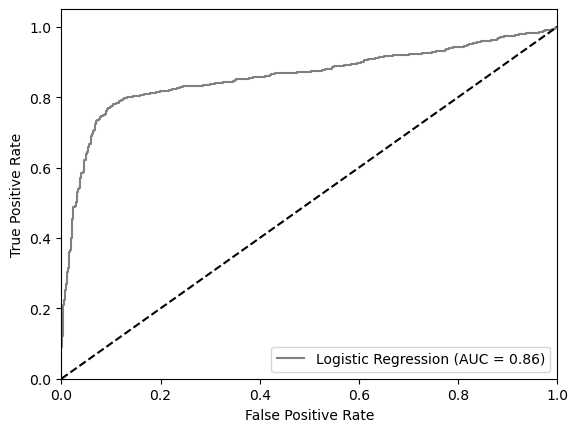

In [37]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='gray',label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
#plt.savefig('embed_link.eps')
plt.show();

## Larger study -- use classification accuracy for comparing embeddings

We saw earlier an **unsupervised** method for selecting good graph embeddings where we computed some divergence score. In **supervised** case, it is usually better to take advantage of the known labels to compare embeddings.
With this larger experiment, we do the following using the 1,000 nodes ABCD graph. Recall that in this case, the class is the ground-truth community for each node. 

* we partition the nodes into training, validation and test sets in proportion 25%/25%/50%
* we generate 70 different embeddings (3 algorithms, different parameters)
* from each embedding, 
 * we compute the JS divergence (unsupervised score)
 * we use the training data to build a classification model (random forest)
 * we apply this model to the validation set 
 * we compute the accuracy score (supervised score) 

The code to do this is commented out in the cell below as this can take several minutes to run. 
A pickle file with the results is included in data directory and can be read directly.
If you re-run from scratch, the results can differ slightly due to non-deterministic algorithms like node2vec.


In [38]:
## load results from pickle file
with open(datadir+"ABCD/abcd_1000_embeddings.pkl","rb") as f:
    id_train,id_val,id_trainval,id_test,L = pickle.load(f)

## labels for train/validation/test sets
y_all = ABCD.vs['comm']
y_train = [y_all[i] for i in id_train]
y_trainval = [y_all[i] for i in id_trainval] ## training+validation sets
y_val = [y_all[i] for i in id_val]
y_test = [y_all[i] for i in id_test]


Below we compute the rank-based  Kendall-tau correlation between the divergence score (unsupervised) and the accuracy score (supervised). We see negative correlation which is to be expected since respectively low divergence and high accuracy are better.

In [39]:
## correlation: divergence and accuracy
R = pd.DataFrame(L,columns=['dim','algo','param','div_g','div_l','acc'])
from scipy.stats import kendalltau as tau
print(tau(R['div_g'],R['acc']))
print(tau(R['div_l'],R['acc']))


SignificanceResult(statistic=-0.7625166744806207, pvalue=4.463999107499204e-12)
SignificanceResult(statistic=-0.4313225633425733, pvalue=9.029967534639656e-05)


In the next 2 cells, we show the top results on the validation set respectively for the divergence and accuracy scores. We also add two columns with the respective ranks.


In [40]:
## sort by JS-divergence on validation set
size = R.shape[0]
R = R.sort_values(by='div_g',axis=0,ascending=True)
R['rank_div_g'] = np.arange(1,size+1,1)
R = R.sort_values(by='div_l',axis=0,ascending=True)
R['rank_div_l'] = np.arange(1,size+1,1)
R['rank_div'] = (R['rank_div_g'] + R['rank_div_l'])/2
R = R.sort_values(by='rank_div',axis=0,ascending=True)


,dim,algo,param,div_g,div_l,acc,rank_div_g,rank_div_l,rank_div
4,32,le,0,0.000746,0.0229,0.908,1,1,1.0
24,32,hope,ppr,0.001945,0.0570,0.888,3,2,2.5
3,16,le,0,0.001165,0.0696,0.920,2,3,2.5
20,16,hope,ppr,0.002129,0.1094,0.900,4,4,4.0
2,8,le,0,0.007074,0.1284,0.868,6,5,5.5


In [41]:
## sort by Accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
size = R.shape[0]
R['rank_acc'] = np.arange(1,size+1,1)
R.head()


,dim,algo,param,div_g,div_l,acc,rank_div_g,rank_div_l,rank_div,rank_acc
3,16,le,0,0.001165,0.0696,0.920,2,3,2.5,1
4,32,le,0,0.000746,0.0229,0.908,1,1,1.0,2
20,16,hope,ppr,0.002129,0.1094,0.900,4,4,4.0,3
24,32,hope,ppr,0.001945,0.0570,0.888,3,2,2.5,4
2,8,le,0,0.007074,0.1284,0.868,6,5,5.5,5


Below we show the lowest accuracy results. We see that there is quite a range of accuracy on the validation set!


In [42]:
R.tail()

,dim,algo,param,div_g,div_l,acc,rank_div_g,rank_div_l,rank_div,rank_acc
26,2,n2v,0.5 1,0.072984,0.2750,0.192,40,30,35.0,36
5,2,hope,katz,0.061800,0.2897,0.188,37,37,37.0,37
8,2,hope,ppr,0.060917,0.2570,0.176,36,26,31.0,38
27,2,n2v,1 1,0.070804,0.2793,0.152,39,32,35.5,39
25,2,n2v,1 0.5,0.070208,0.2831,0.128,38,34,36.0,40


###  Apply the models to the test set. 

In the previous cells, we built a table ranking the different algorithms w.r.t. accuracy and divergence using the training and validation sets. Here, we go through the same algorithms in (decreasing) order of accuracy, re-train with each model using the training and validation sets, and apply to the test set.

This takes several minutes to run so a pickle file is provided with the results.

Uncomment the cell below to re-run; results can differ in that case due to non-deterministic algorithms like node2vec

In [43]:
## load test results
with open(datadir+"ABCD/abcd_1000_embeddings_test.pkl","rb") as f:
    top_acc = pickle.load(f)
R['test'] = top_acc
print('mean accuracy over all models on the test set:',np.mean(R['test']))


mean accuracy over all models on the test set: 0.57325


In [44]:
## top results w.r.t. accuracy on the test set
R = R.sort_values(by='test',axis=0,ascending=False)
R['rank_test'] = np.arange(1,size+1,1)
R.head()

,dim,algo,param,div_g,div_l,acc,rank_div_g,rank_div_l,rank_div,rank_acc,test,rank_test
4,32,le,0,0.000746,0.0229,0.908,1,1,1.0,2,0.952,1
3,16,le,0,0.001165,0.0696,0.920,2,3,2.5,1,0.950,2
20,16,hope,ppr,0.002129,0.1094,0.900,4,4,4.0,3,0.940,3
24,32,hope,ppr,0.001945,0.0570,0.888,3,2,2.5,4,0.938,4
2,8,le,0,0.007074,0.1284,0.868,6,5,5.5,5,0.904,5


Next, we take the top-10 algorithms w.r.t. divergence on the validation set, and the top-10 algorithms w.r.t. accuracy on the valudation set. We then plot the distribution of results (accuracy) over the test set via box-plots.

As expected, using accuracy (supervised score) yields better results, but the results obtained with the (unsupervised) divergence score are also quite good.


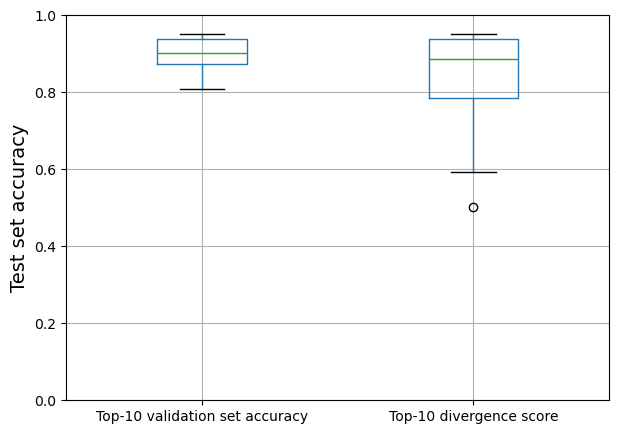

In [45]:
## top results on test set w.r.t. divergence on validation set
R = R.sort_values(by='rank_div',axis=0,ascending=True)
top_div = R['test'].iloc[:10]

## top results on test set w.r.t. accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
top_acc = R['test'].iloc[:10]

## pd with mu
B = pd.DataFrame(np.transpose(np.array([top_acc,top_div])), 
                 columns=['Top-10 validation set accuracy','Top-10 divergence score'])
B.boxplot(rot=0,figsize=(7,5), widths=.33)
plt.ylim((0,1))
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('embed_classify.eps')


Another way to compare the results is to plot the accuracy results on the test set as a function of the rank of the algorithms w.r.t. the accuracy score on the validation set (next cell) or the divergence score on the validation set (second next cell).

The correlation is very clear in the first case, and is still quite strong in the second case.

correlation: -0.9850260376346469


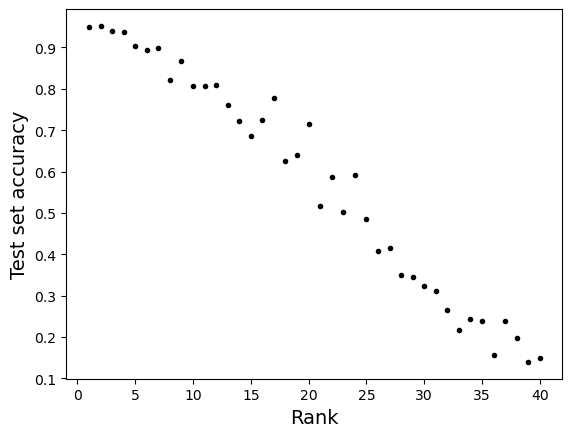

In [46]:
plt.plot(R['rank_acc'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_accuracy.eps');
print('correlation:',np.corrcoef(R['rank_acc'],R['test'])[0,1])

correlation: -0.9202638327279603


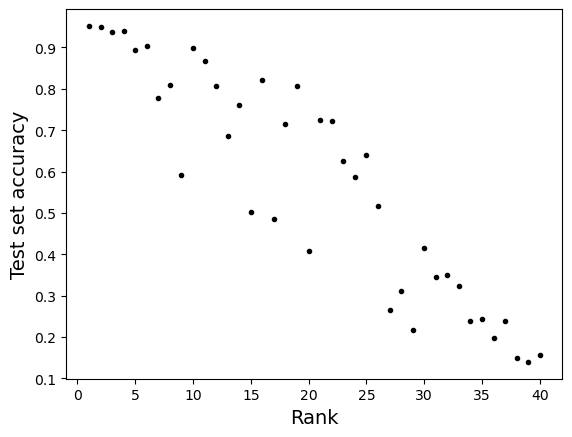

In [47]:
plt.plot(R['rank_div_g'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_divergence.eps');
print('correlation:',np.corrcoef(R['rank_div_g'],R['test'])[0,1])

Finally, we compare with accuracy obtained with a random classifier, averaging over several runs.

In [48]:
## random classification
ctr = Counter(y_trainval)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
acc = []
for rep in range(30):
    y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
    cm = confusion_matrix(y_test, y_pred)
    acc.append(sum(cm.diagonal())/sum(sum(cm)))
print('\nRandom classifier average accuracy on test set:',np.mean(acc))



Random classifier average accuracy on test set: 0.0882


In [ ]:
from scipy.stats import rankdata

## try with top-k embeddings together - hopefully this consistently yields high AUC
k = 7
cfg.vs['rank'] = 0
for i in range(k):
    dim = D.iloc[i]['dim']
    p = float(D.iloc[i]['param'].split()[0])
    q = float(D.iloc[i]['param'].split()[1])
    x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    ## if you get unstable results, you can try with shorter random walks, for example:
    ## x = 'node2vec -l:15 -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x+' >/dev/null 2>&1') ## to avoid long output
    jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
    cfg.vs['ent'] = list(pd.read_csv('_entropy',header=None)[1])
    rk = rankdata(cfg.vs['ent'])
    for i in range(len(rk)):
        cfg.vs[i]['rank'] += rk[i] ## add ranks
print('AUC: ',roc_auc_score(cfg.vs['anomaly'], cfg.vs['rank']))

# New material - GCN 

In [51]:
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.cluster import KMeans
import seaborn as sns
from sknetwork.classification import get_accuracy_score


## GCN+kmeans structural embedding of Zachary graph

In the first cell below, we embed the nodes from the ZAchary graph using a simple GCN model (graph convolution net) with one hidden layer and 3-dim output. This can be done via ```fit_transform```. For structural node features, we use each node's degree and number of edges in its egonet. We cluster the resulting embedding with k-means setting k=3. We see that this embedding finds the central/intermediate/peripherial nodes as its clusters.

We then train another GCN but with 1-dim output layer (same node features), so we get a 1-dim embedding that we can use to order the nodes, which we show in the second cell below (where the node labels are now the respective ranks). We see a clear ranking from the most central nodes to the peripherial nodes.


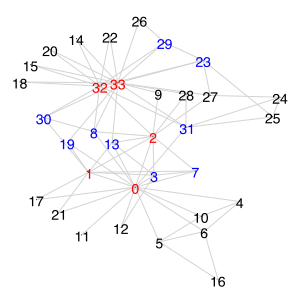

In [55]:
## GCN embedding of karate graph + kmeans with 3 communities
graph = skn.data.karate_club(metadata=True)
A = graph.adjacency
g = ig.Graph.Adjacency(A, 'undirected')
g.vs['label'] = [int(i) for i in range(g.vcount())]

## GCN
hidden_dim = 5
n_labels = 3
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for structural features, use degree and edges in egonet
features = np.stack( (
    np.array(g.degree()),
    np.array([g.subgraph(V).ecount() for V in g.neighborhood()]),
    ), axis=1 
)
labels = np.zeros(g.vcount()) ## embedding, no need for node labels
emb = gnn.fit_transform(A, features, labels=labels, n_epochs=20, random_state=42, history=True)

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(emb)
g.vs['kmeans'] = kmeans.labels_
cls = ['red','blue','black']
g.vs['label_color'] = [cls[i] for i in kmeans.labels_]
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1)


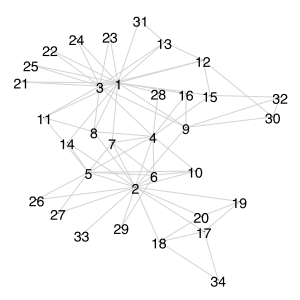

In [56]:
## 1-d embedding allows for node ordering
n_labels = 1
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)
emb1 = gnn.fit_transform(A, features, labels=labels, n_epochs=100, random_state=42, history=True)
roles = np.argsort(emb1.flatten())
for i in range(len(roles)):
    g.vs[roles[i]]['label'] = i+1
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_color='black')


## semi-supervised learning with GCN

Below we consider the ground-turth labels in the Zachary graphs; recall that there are two communities. We mask 1/3 of the labels and train a GCN model using the other 2/3, given the grounbd-truth labels for those. We then use the trained model to predict the labels for the masked 1/3 of the nodes (a.k.a. the test set).


In [59]:
## classification - karate graph
A = g.get_adjacency_sparse()
labels = graph.labels.copy()

np.random.seed(123)
train_mask = np.random.random(size=len(labels)) < 0.33 ## mask 1/3 of the nodes for training

labels[train_mask] = -1 ## negative labels are ignored

# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = 2 ## 2 ground-truth communities 

gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for features, simply use shortest path len to all nodes, or just the adjacency matrix
features = A
Pred = gnn.fit_predict(A, features, labels=labels, n_epochs=100, random_state=42, history=True)
acc = get_accuracy_score(graph.labels[train_mask], Pred[train_mask])
print('accuracy on the test set:', acc)

accuracy on the test set: 0.8888888888888888


## GCN+kmeans structural embedding of the airport graph 

Same procedure as above, but with the airport graph (undirected, unweighted).

This is a larger graph, so visualization is less useful here. To validate the results, we plot the distribution of the PageRank values for the 3 structural communities we obtained, and we show the airports from California that belong to each cluster.


In [72]:
## load the airport dataset

## read edges and build weighted directed graph
df = pd.read_csv(datadir+'Airports/connections.csv')
g_airport = ig.Graph.TupleList([tuple(x) for x in df.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
Attr = pd.read_csv(datadir+'Airports/airports_loc.csv')

## map airports in Attr to the node order in graph g
lookup = {k:v for v,k in enumerate(Attr['airport'])}
l = [lookup[x] for x in g_airport.vs()['name']]

## save lat/lon as tuples for each node:
g_airport.vs()['layout'] = [(Attr['lon'][i],Attr['lat'][i]) for i in l]
g_airport.vs()['state'] = [Attr['state'][i] for i in l]
g_airport.vs()['city'] = [Attr['city'][i] for i in l]




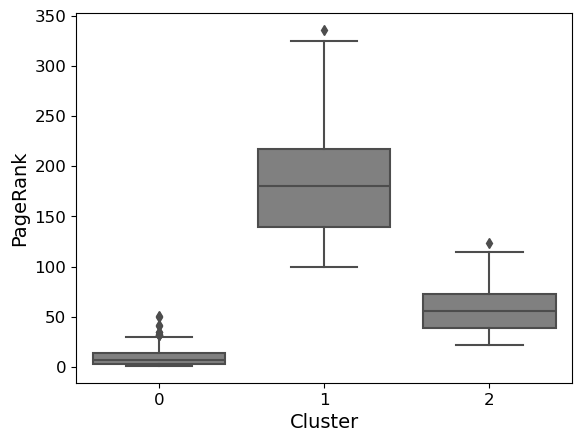

In [73]:
## GCN embedding of airport graph + kmeans with 3 communities
A = g_airport.get_adjacency_sparse()
hidden_dim = 5
n_labels = 4

gnn = skn.gnn.GNNClassifier(dims=[hidden_dim,hidden_dim,n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for structural features, use degree and edges in egonet
features = np.stack( (
    np.array(g_airport.degree()),
    np.array([g_airport.subgraph(V).ecount() for V in g_airport.neighborhood()]),
    ), axis=1 
)

labels = np.zeros(g_airport.vcount())
emb = gnn.fit_transform(A, features, labels=labels, n_epochs=100, random_state=123, history=False)

## get 3 clusters from the embedding
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(emb)
g_airport.vs['kmeans'] = kmeans.labels_

cls = ['gray']
df = pd.DataFrame()
df['degree'] = g_airport.degree()
df['kmeans'] = g_airport.vs['kmeans']
df['pr'] = g_airport.pagerank()

## boxplots
bp = sns.boxplot(data=df, x='kmeans', y='degree', palette=cls);
bp.set_xlabel("Cluster", fontsize=14)
bp.set_ylabel("PageRank", fontsize=14)
bp.tick_params(labelsize=12)
plt.show()
#plt.savefig('fn.eps');


In [74]:
for i in range(3):
    print('Cluster ',str(i),':',[v['name'] for v in g_airport.vs if v['state']=='CA' and v['kmeans']==i])
          

Cluster  0 : ['SBP', 'ACV', 'STS', 'RDD', 'SCK', 'MOD', 'CIC', 'OXR', 'CEC', 'IPL', 'MCE', 'VIS', 'RIV', 'NZY', 'NKX', 'MHR', 'SEE', 'MCC', 'SDM', 'TKF', 'APC']
Cluster  1 : ['SFO', 'LAX', 'SAN', 'OAK', 'SNA', 'SJC', 'SMF']
Cluster  2 : ['FAT', 'SBA', 'BFL']


## 3-state airport subgraph - GCN semi-supervised learning


Airport subgraph: 36 nodes and 145 edges


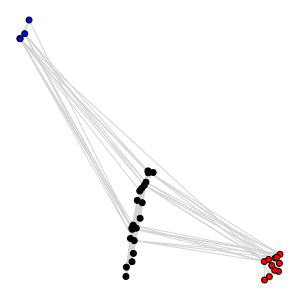

In [75]:
states = ['HI','PA','CA']
cls = ['blue','red','black']
cls_dict = {i:j for i,j in zip(states,cls)}

## subgraph, pick a few states
V = [v for v in g_airport.vs if v['state'] in states]
sg = g_airport.subgraph(V)
sg = sg.connected_components(mode='weak').giant()
sg = sg.simplify()
sg = sg.as_undirected()
sg.vs['size'] = 6
for v in sg.vs:
    v['color'] = cls_dict[v['state']]
print('Airport subgraph:', sg.vcount(), 'nodes and', sg.ecount(), 'edges')
ig.plot(sg, layout=sg.vs['layout'], bbox=(300,300), edge_color='lightgrey')

Reading graph:   0%|                                                                               | 0/145 [00…

Epochs:   0%|                                                                                      | 0/100 [00…

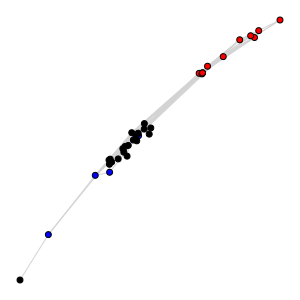

In [76]:
## nkde2vec in 2-dim
graph = Graph(sg.to_tuple_list(), directed=False, weighted=False)
n2v = Node2Vec(graph, dim=2, walk_length=100, window=5, workers=1, seed=123)
n2v.train(epochs=100)
ly = [n2v.wv[i] for i in range(len(n2v.wv))]
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey')


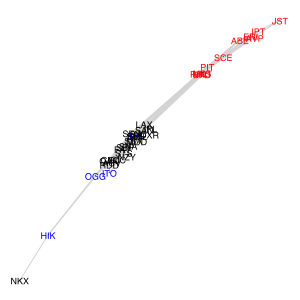

In [77]:
# NKX and HIK are air force bases
for v in sg.vs:
    v['label_color'] = v['color']
    v['label'] = v['name']
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)

Epochs:   0%|                                                                                      | 0/100 [00…

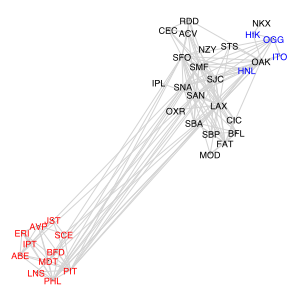

In [78]:
## n2v with dim=8, then viz in 2d with umap
n2v = Node2Vec(graph, dim=16, walk_length=80, window=5, workers=1, seed=123)
n2v.train(epochs=100)
Y = np.array([n2v.wv[i] for i in range(len(n2v.wv))])
ly = umap.UMAP(random_state=42, n_jobs=1).fit_transform(Y)
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)

In [79]:
A = sg.get_adjacency_sparse()

# Training set
dct = {j:i for i,j in enumerate(states)} ## use integers for the class labels
labels = np.array([dct[i] for i in sg.vs['state']])

np.random.seed(123)
train_mask = np.random.random(size=len(labels)) < 0.3

labels[train_mask] = -1 ## negative labels are ignored
sg.vs['class'] = labels

# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = len(states)

gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for features, simply use shortest path len to all nodes, or just the adjacency matrix
features = np.array(sg.distances(mode='all'))

Pred = gnn.fit_predict(A, features, labels=labels, n_epochs=100, random_state=42, history=True)
labels = np.array([dct[i] for i in sg.vs['state']])
get_accuracy_score(labels[train_mask], Pred[train_mask])

0.875